<a href="https://colab.research.google.com/github/haleemiliyash/ASAP-polaris-blind-challenge-Ligand-ADMET-property-prediction-/blob/main/Polaris_ADMET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# asap-discovery/antiviral-admet-2025

Absorption, Distribution, Metabolism, Excretion, Toxicology - or ADMET - endpoints sit in the middle of the assay cascade and can make or break preclinical candidate molecules. For this blind challenge we selected several crucial endpoints for the community to predict:

**Mouse Liver Microsomal stability (MLM, protocol)**: This is a stability assay that tests how quickly a molecule gets broken down by mouse liver microsomes. This is a useful assay that can be used as an estimate on how long a molecule will reside in the mouse body before it gets cleared.

**Human Liver Microsomal stability (HLM, protocol):** This is a stability assay that tests how quickly a molecule gets broken down by human liver microsomes. This is a useful assay that can be used as an estimate on how long a molecule will reside in the human body before it gets cleared.

**Solubility (KSOL, protocol):** solubility is essential for drug molecules: this heavily affects the pharmacokinetic and dynamics ('PKPD') of the molecule in the human body.

**LogD (protocol):** like solubility - but then in fatty tissue - LogD is a measure of a molecule's lipophilicity, or how well it dissolves in fat. LogD is calculated by comparing a molecule's solubility in octanol, a fat-like substance, to its solubility in water.

**Cell permeation (MDR1-MDCKII, protocol):** MDCKII-MDR1 is a cell line that's used to model cell permeation i.e. how well drug compounds will permeate cell layers. For coronaviruses this is a critical endpoint because there is increasing evidence that afflictions such as long-covid are caused by (remnant) virus particles in the brain, and blood-brain-barrier (BBB) permeation is critical for drug candidates to reach the brain.

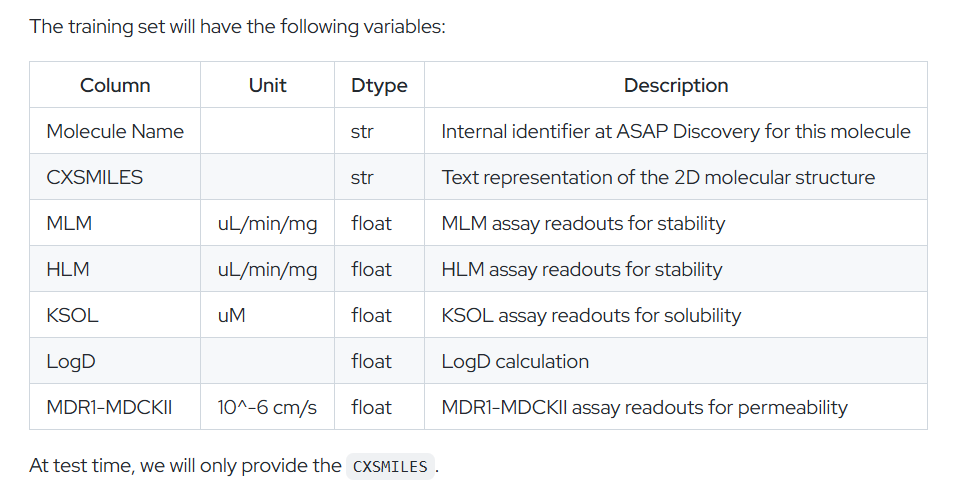


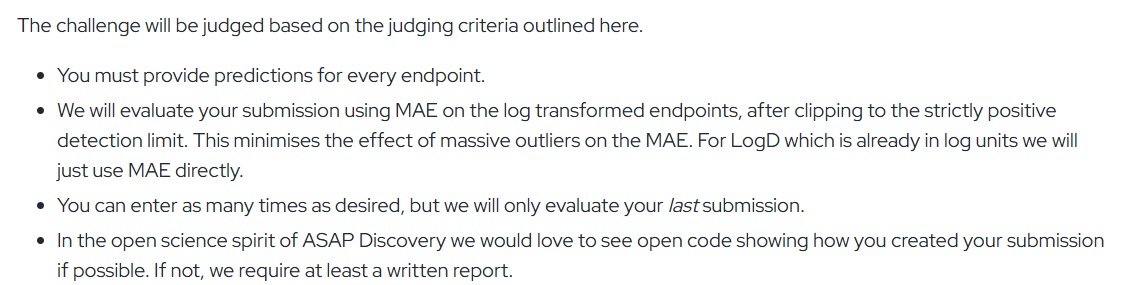

Refer Website:https://polarishub.io/competitions/asap-discovery/antiviral-admet-2025

In [ ]:
!pip install polaris-lib

In [ ]:
import polaris as po
from polaris.hub.client import PolarisHubClient

In [ ]:
client = PolarisHubClient()# Portal Login
client.login()

In [ ]:
CHALLENGE = "antiviral-admet-2025"  # or: "antiviral-potency-2025"

In [ ]:
import polaris as po

competition = po.load_competition(f"asap-discovery/{CHALLENGE}")

In [ ]:
competition.cache()

In [ ]:
competition


In [ ]:
train, test = competition.get_train_test_split()

In [ ]:
import pandas as pd

In [ ]:
train[0]

In [ ]:
train[1]

In [ ]:
test_DF=pd.DataFrame(test)
test_DF

In [ ]:
train_DF=pd.DataFrame(train)
train_DF

In [ ]:
train_DF = train_DF.rename(columns={0:'CXSMILE'})
train_DF = train_DF.rename(columns={1:'ENDPOINT'})
train_DF

In [ ]:
import pickle
import json
# Pickle the DataFrame and save it as a JSON file
with open("train_DF.json", "wb") as f:
    pickle.dump(train_DF, f)

#Expolaratory Data Analysis(EDA)

In [ ]:
ENDPOINT_train_DF = pd.json_normalize(train_DF['ENDPOINT']) # concat the smile and End ponit
train_DF=pd.concat([train_DF, ENDPOINT_train_DF],axis=1)
train_DF

In [ ]:
train_DF = train_DF.drop(['ENDPOINT'], axis=1)
train_DF

In [ ]:
train_DF.info()

In [ ]:
train_DF.shape

In [ ]:
train_DF.isnull().sum()

#Visulaization of Data and Outlier

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
columns=['MDR1-MDCKII','LogD','HLM','MLM','KSOL']
for i in columns:
  sns.boxplot(x=train_DF[i])
  plt.xlabel(i)
  plt.show()

In [ ]:
train_DF


# Used Lipinski descriptors for Feature Engineering

Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:
*   Molecular weight < 500 Dalton
*   Octanol-water partition coefficient (LogP) < 5
*   Hydrogen bond donors < 5
*   Hydrogen bond acceptors < 10

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

# To calculate Lipinski descriptors including additional properties
def get_lipinski_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mw = Descriptors.MolWt(mol)                           # Molecular Weight
        logp = Descriptors.MolLogP(mol)                      # LogP (Octanol-Water Partition Coefficient)
        hbd = Descriptors.NumHDonors(mol)                    # Number of Hydrogen Bond Donors
        hba = Descriptors.NumHAcceptors(mol)                 # Number of Hydrogen Bond Acceptors
        tpsa = Descriptors.TPSA(mol)                         # Topological Polar Surface Area (TPSA)
        rot_bonds = Descriptors.NumRotatableBonds(mol)       # Number of Rotatable Bonds
        arom_rings = Descriptors.NumAromaticRings(mol)       # Number of Aromatic Rings
        flex = Descriptors.FractionCSP3(mol)                 # Molecular Flexibility (Fraction of sp3 hybridized carbons)
        return pd.Series([mw, logp, hbd, hba, tpsa, rot_bonds, arom_rings, flex])
    else:
        return pd.Series([None, None, None, None, None, None, None, None])

# Add Lipinski descriptors and additional properties to DataFrame
train_DF[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3']] = train_DF['CXSMILE'].apply(get_lipinski_descriptors)


# In Sample dataset some target value are NAN so filling NaN value with similar Cxsimiles value and Converting the Cxsmile into Vector

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Descriptors
import pandas as pd
import numpy as np
import pickle
import warnings
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")  # Suppress warnings

# Convert SMILES to RDKit Morgan fingerprints (ExplicitBitVect)
def smiles_to_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)  # ExplicitBitVect
    return None

train_DF['fingerprint'] = train_DF['CXSMILE'].apply(smiles_to_fingerprint)

# Convert fingerprints to numerical arrays
fingerprint_array = []
for fp in train_DF["fingerprint"]:
    arr = np.zeros((1,), dtype=int)
    if fp is not None:
        DataStructs.ConvertToNumpyArray(fp, arr)
    fingerprint_array.append(arr)

fingerprint_matrix = np.array(fingerprint_array)

# Compute additional molecular descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return pd.Series([
            Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
            Descriptors.NumHDonors(mol), Descriptors.NumHAcceptors(mol),
            Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol),
            Descriptors.NumAromaticRings(mol), Descriptors.FractionCSP3(mol)
        ])
    else:
        return pd.Series([None] * 8)

train_DF[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA',
          'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3']] = train_DF['CXSMILE'].apply(compute_descriptors)

# Combine molecular descriptors with fingerprints
molecular_descriptors = train_DF[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA',
                                  'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3']].values
X_full = np.hstack([fingerprint_matrix, molecular_descriptors])

# Standardizing the features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# Apply PCA to reduce dimensionality while preserving variance
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled)

# Columns with missing values to impute
cols = ['MLM', 'HLM', 'LogD', 'KSOL', 'MDR1-MDCKII']
y_full = train_DF[cols].values

# Apply Iterative Imputer
iter_imputer = IterativeImputer(max_iter=10, random_state=3)
y_imputed = iter_imputer.fit_transform(y_full)

# Assign back the imputed values
train_DF[cols] = y_imputed

# Save processed dataset
train_DF.to_csv("pca_imputed_train_DF.csv", index=False)

# Display PCA explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the updated DataFrame
print(train_DF.head())

# All NaN value filled

In [ ]:
train_DF.isnull().sum()

# Data distribution in dataset

In [ ]:
for i in columns:
    sns.distplot(train_DF[i])
    plt.title(i)
    plt.show()

# Finding skewness value

In [ ]:
import scipy
columns=['MDR1-MDCKII','LogD','HLM','MLM','KSOL']
for j in columns:
  sk_value_1=scipy.stats.skew(train_DF[j], axis=0, bias=True)
  print(sk_value_1)

In [ ]:
train_DF['LogD'].max()

In [ ]:
train_DF['MDR1-MDCKII'].max()

In [ ]:
train_DF['HLM'].max()

In [ ]:
train_DF['MLM'].max()

In [ ]:
train_DF['KSOL'].max()

#Log transformation

In [ ]:
from sklearn.preprocessing import PowerTransformer
import numpy as np
data=train_DF['MDR1-MDCKII']
C = abs(np.min(data)) + 1  # Shift to make all values positive
train_DF['MDR1-MDCKII']= np.log1p(data + C)

In [ ]:
train_DF['MDR1-MDCKII'].max()

In [ ]:
sk_value_1=scipy.stats.skew(train_DF['MDR1-MDCKII'], axis=0, bias=True)
print(sk_value_1)

In [ ]:
from sklearn.preprocessing import PowerTransformer
import numpy as np
col=['HLM','MLM','KSOL']
for i in col:
  data=train_DF[i]
  C = abs(np.min(data)) + 1  # Shift to make all values positive
  train_DF[i]= np.log1p(data + C)

In [ ]:
import scipy
column=['MDR1-MDCKII','HLM','MLM']
for j in column:
  sk_value_1=scipy.stats.skew(train_DF[j], axis=0, bias=True)
  print(sk_value_1)

In [ ]:
columns=['MDR1-MDCKII','LogD','HLM','MLM','KSOL']
for i in columns:
  sns.boxplot(x=train_DF[i])
  plt.xlabel(i)
  plt.show()

In [ ]:
train_DF['LogP'].max()

#Correlation with Each feature

In [ ]:
x=train_DF[['MDR1-MDCKII','LogD','HLM','MLM','KSOL','MolWt','LogP','NumHDonors','NumHAcceptors']].corr()
sns.heatmap(x, annot=True, cmap="coolwarm")

In [ ]:
train_DF

# Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import numpy as np

features = ['MDR1-MDCKII', 'LogD', 'HLM', 'MLM', 'KSOL']
for i in features:
    # Convert 'fingerprint' to a numerical format
    X = np.array([list(map(int, fp)) for fp in train_DF['fingerprint']])
    other_features = train_DF[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3']].values

    x = np.hstack([X, other_features])  # Merge all features

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=0.95)  # Retain 95% of variance
    x_pca = pca.fit_transform(x)

    y = train_DF[i].values
    x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=3)

    # Use Linear Regression
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Predictions
    y_pred = model.predict(x_test)

    # Evaluation metrics
    r2_score = model.score(x_test, y_test)  # R² Score
    mae = mean_absolute_error(y_test, y_pred)  # MAE

    print(i)
    print(f"R² score for {i}: {r2_score:.4f}")
    print(f"MAE for {i}: {mae:.4f}")




# Decision tree regressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

features = ['MDR1-MDCKII', 'LogD', 'HLM', 'MLM', 'KSOL']

for i in features:
    # Convert 'Fingerprint' to a numerical format
    X = np.array([list(map(int, fp)) for fp in train_DF['fingerprint']])

    # Include all molecular descriptors
    other_features = train_DF[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors',
                               'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3']].values

    x = np.hstack([X, other_features])  # Merge all features
    y = train_DF[i].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

    # Initialize and train Decision Tree Regressor
    model = DecisionTreeRegressor(random_state=3)
    model.fit(x_train, y_train)

    # Predictions
    y_pred = model.predict(x_test)

    # Evaluation metrics
    r2_score = model.score(x_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"{i}")
    print(f"R² score for {i}: {r2_score:.4f}")
    print(f"MAE for {i}: {mae:.4f}\n")

# Random forest regressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

features = ['MDR1-MDCKII', 'LogD', 'HLM', 'MLM', 'KSOL']

for i in features:
    # Convert 'Fingerprint' to a numerical format
    X = np.array([list(map(int, fp)) for fp in train_DF['fingerprint']])

    # Include all molecular descriptors
    other_features = train_DF[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors',
                               'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3']].values

    x = np.hstack([X, other_features])  # Merge all features
    y = train_DF[i].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

    # Initialize and train Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=3)
    model.fit(x_train, y_train)

    # Predictions
    y_pred = model.predict(x_test)

    # Evaluation metrics
    r2_score = model.score(x_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Feature: {i}")
    print(f"R² score for {i}: {r2_score:.4f}")
    print(f"MAE for {i}: {mae:.4f}\n")


#Gradient Boosting Regressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

features = ['MDR1-MDCKII', 'LogD', 'HLM', 'MLM', 'KSOL']

for i in features:
    # Convert 'Fingerprint' to a numerical format
    X = np.array([list(map(int, fp)) for fp in train_DF['fingerprint']])

    # Include all molecular descriptors
    other_features = train_DF[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors',
                               'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3']].values

    x = np.hstack([X, other_features])  # Merge all features
    y = train_DF[i].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

    # Initialize and train Gradient Boosting Regressor
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=3)
    model.fit(x_train, y_train)

    # Predictions
    y_pred = model.predict(x_test)

    # Evaluation metrics
    r2_score = model.score(x_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print(f"Feature: {i}")
    print(f"R² score for {i}: {r2_score:.4f}")
    print(f"MAE for {i}: {mae:.4f}")
    print(f"MSE for {i}: {mse:.4f}\n")


# XG Boost Regression

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

features = ['MDR1-MDCKII', 'LogD', 'HLM', 'MLM', 'KSOL']

for i in features:
    # Convert 'Fingerprint' to a numerical format
    X = np.array([list(map(int, fp)) for fp in train_DF['fingerprint']])

    # Include all molecular descriptors
    other_features = train_DF[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors',
                               'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3']].values

    # Merge RDKit fingerprints with molecular descriptors
    x = np.hstack([X, other_features])
    y = train_DF[i].values

    # Split the dataset
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

    # Initialize and train XGBoost Regressor
    model = XGBRegressor(
        n_estimators=200,         # Increased estimators for better performance
        learning_rate=0.05,       # Lower learning rate for stable convergence
        max_depth=6,              # Increased depth to capture complex patterns
        subsample=0.8,            # Subsampling to reduce overfitting
        colsample_bytree=0.8,     # Feature sampling per tree
        random_state=3,
        objective='reg:squarederror'
    )
    model.fit(x_train, y_train)

    # Predictions
    y_pred = model.predict(x_test)

    # Evaluation metrics
    r2_score = model.score(x_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print(f"Feature: {i}")
    print(f"R² score for {i}: {r2_score:.4f}")
    print(f"MAE for {i}: {mae:.4f}")
    print(f"MSE for {i}: {mse:.4f}\n")

In [ ]:
test_DF

In [ ]:
test_DF = test_DF.rename(columns={0:'CXSMILE'})

In [ ]:
test_DF

In [ ]:
import pickle
import json
# Pickle the DataFrame and save it as a JSON file
with open("test_DF.json", "wb") as f:
    pickle.dump(test_DF, f)

# Convert Fingerprint into Vector

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import pandas as pd
import numpy as np
import pickle
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings

unique_dist = {}

i = "CXSMILE"  # Ensure column name matches exactly

# Store initial unique SMILES
unique_dist[f'{i}_initial'] = test_DF[i].unique().tolist()

# Convert SMILES to RDKit Morgan fingerprints (ExplicitBitVect)
def smiles_to_fingerprint(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)  # ExplicitBitVect
    return None

test_DF['fingerprint'] = test_DF[i].apply(smiles_to_fingerprint)

# Convert fingerprints to tuples for unique identification
fingerprint_tuples = []
for fp in test_DF["fingerprint"].dropna():
    arr = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    fingerprint_tuples.append(tuple(arr))

# Store final unique fingerprints
unique_dist[f'{i}_Final'] = sorted(set(fingerprint_tuples))

In [ ]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

# To calculate Lipinski descriptors including additional properties
def get_lipinski_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mw = Descriptors.MolWt(mol)                           # Molecular Weight
        logp = Descriptors.MolLogP(mol)                      # LogP (Octanol-Water Partition Coefficient)
        hbd = Descriptors.NumHDonors(mol)                    # Number of Hydrogen Bond Donors
        hba = Descriptors.NumHAcceptors(mol)                 # Number of Hydrogen Bond Acceptors
        tpsa = Descriptors.TPSA(mol)                         # Topological Polar Surface Area (TPSA)
        rot_bonds = Descriptors.NumRotatableBonds(mol)       # Number of Rotatable Bonds
        arom_rings = Descriptors.NumAromaticRings(mol)       # Number of Aromatic Rings
        flex = Descriptors.FractionCSP3(mol)                 # Molecular Flexibility (Fraction of sp3 hybridized carbons)
        return pd.Series([mw, logp, hbd, hba, tpsa, rot_bonds, arom_rings, flex])
    else:
        return pd.Series([None, None, None, None, None, None, None, None])

# Add Lipinski descriptors and additional properties to DataFrame
test_DF[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3']] = test_DF['CXSMILE'].apply(get_lipinski_descriptors)

In [ ]:
test_DF

# Based on R2 & MAE Value XG Boost Regression model are good

In [ ]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

features = ['MDR1-MDCKII', 'LogD', 'HLM', 'MLM', 'KSOL']
best_Predict = {}

for i in features:
    # Convert 'Fingerprint' to a numerical format
    X = np.array([list(map(int, fp)) for fp in train_DF['fingerprint']])

    # Include all molecular descriptors
    other_features = train_DF[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors',
                               'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3']].values

    # Merge RDKit fingerprints with molecular descriptors
    x = np.hstack([X, other_features])
    y = train_DF[i].values

    # Convert test fingerprints to numerical format
    X_test = np.array([list(map(int, fp)) for fp in test_DF['fingerprint']])
    other_features_test = test_DF[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors',
                                   'TPSA', 'NumRotatableBonds', 'NumAromaticRings', 'FractionCSP3']].values

    # Merge all features for test data
    z = np.hstack([X_test, other_features_test])

    # Split training data for evaluation
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

    # Hyperparameter tuning for XGBoost
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    xgb = XGBRegressor(objective='reg:squarederror', random_state=3)
    grid_search = GridSearchCV(xgb, param_grid, cv=3, n_jobs=-1, scoring='r2')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_

    # Predictions on test dataset
    y_pred = best_model.predict(z)

    # Evaluation metrics on validation set
    r2_score = best_model.score(x_test, y_test)
    mae = mean_absolute_error(y_test, best_model.predict(x_test))

    # Store predictions in dictionary
    best_Predict[i] = y_pred.tolist()

    print(f"Feature: {i}")
    print(f"Best Params: {grid_search.best_params_}")
    print(f"R² score on validation: {r2_score:.4f}")
    print(f"MAE on validation: {mae:.4f}\n")

print(best_Predict)



In [ ]:
best_Predict

In [ ]:
with open("Best_predict.json", "w") as f:
    json.dump(best_Predict, f)


In [ ]:
# Load the JSON file
file_path = "/content/Best_predict.json"
with open(file_path, "r") as f:
    predictions = json.load(f)

# Specify the keys to apply exponential transformation
keys_to_transform = ["MDR1-MDCKII", "HLM", "MLM", "KSOL"]  #Keys

# Apply exponential transformation only to specified keys
for key in keys_to_transform:
    if key in predictions:  #  key in the dictionary
        predictions[key] = np.exp(np.array(predictions[key])).tolist()

# Save the transformed predictions to a new JSON file
with open("final_predict.json","w") as f:
    json.dump(predictions, f, indent=4)

In [ ]:
predictions

In [ ]:
# Convert dictionary to DataFrame and transpose
df_Submission = pd.DataFrame.from_dict(best_Predict, orient='index').transpose()
df_Submission

#Submission of prediction

In [ ]:
competition.submit_predictions(
    predictions=predictions,
    prediction_name="my-admet-predictions",
    prediction_owner="haleemiliyash",
    report_url="https://docs.google.com/document/d/1fAZjJBSr3RDBXpZQNv_tcGKWohCIrPdUZYNf1ku1bYo/edit?usp=sharing",
    github_url="https://github.com/haleemiliyash/ASAP-polaris-blind-challenge-Ligand-ADMET-property-prediction-.git",
    description="prediction data of test dataset(antiviral-admet-2025)",
    tags=["tutorial"],
    user_attributes={"Framework": "Scikit-learn", "Method": "XG boost Regressor"}
)